<a href="https://colab.research.google.com/github/matvuc/MNIST-Dataset-Analysis/blob/main/mlprojectfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORTS

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


# TRANSFORMATIONS

In [ ]:
# define transformations
transform = transforms.Compose([        #combine
    transforms.ToTensor(),                # turn to pytroch tensor
    transforms.Normalize((0.5,), (0.5,))  # refine training
])


# DATA SET

In [ ]:
#training data set
train_dataset = torchvision.datasets.MNIST(
    root='./data',         #directory to save/download the data
    train=True,            #load training set
    transform=transform,   #apply transformations
    download=True          #download the dataset
)


#test data set
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,           #load test set
    transform=transform,    #apply transformations
    download=True         #downlaoded if havent already
)

print(f"\n training data size: {len(train_dataset)} images")
print(f"test data size: {len(test_dataset)} images")


 training data size: 60000 images
test data size: 10000 images


# BATCHING

In [ ]:
#make data loaders for batching / shuffling
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,  #load training dataset
    batch_size=64,          #size of batch
    shuffle=True            #randomize to avoid order based trends
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,   #load test dataset
    batch_size=64,          #load 64 images per batch
    shuffle=False           #no need to shuffle
)


print(f"training batches: {len(train_loader)}")
print(f"test batches: {len(test_loader)}")

training batches: 938
test batches: 157


# VISUALIZE (sanity check)

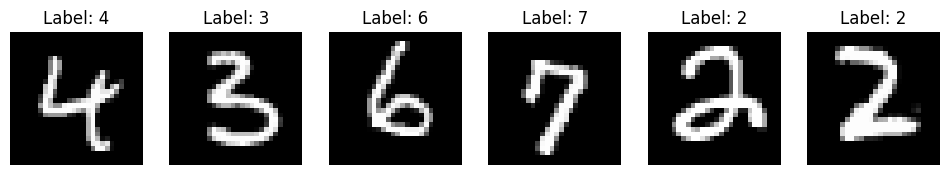

In [ ]:
# get a training batch
examples = iter(train_loader) #loader for 64
images, labels = next(examples) #gets 64 images and 64 corresponding labls

# plot a few images

fig, axes = plt.subplots(1, 6, figsize=(12, 2)) #one row , 6 columns
                                                # 12 by 2 inches canvas



for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap='gray') #remove color dimesnion to fit / greyscale through matplot
    axes[i].set_title(f"Label: {labels[i].item()}") #assign corresponding label to image
    axes[i].axis('off') #removes ticks and labels

plt.show()


# MLP

In [ ]:
#specifically minimizing how many pixls the computer can read
#to metagame the trends that matter to it?

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()   #make neural net class

                                      #Wx+b
        self.layer1 = nn.Linear(28 * 28, 128)  #"translate" image to feature vector  #input neurons / output neurons
        self.layer2 = nn.Linear(128, 64)       #survival of the fittest
        self.layer3 = nn.Linear(64, 10)


    def forward(self, x):
        #pass batch data through the layers
        x = F.relu(self.layer1(x))             #set negative values to zero after layer 1 operations
        x = F.relu(self.layer2(x))             #again after second     (expanding on the linear learning path)
        x = self.layer3(x)                     #return logits to classify
        return x

ACCURACY

In [ ]:
def evaluate_model_accuracy(model, test_loader, flatten=False):
  model.eval()  # turn off dropout, batchnorm (if used)
  correct = 0
  total = 0

  device = next(model.parameters()).device  # Get the device of the model

  with torch.no_grad():  # disables gradient tracking (saves memory)
      for images, labels in test_loader:

          # to gpu
          images, labels = images.to(device), labels.to(device)

          if flatten:
            images = images.view(-1, 28*28)  # flatten test images

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)  # get predicted class index
          total += labels.size(0)  # add batch size to total
          correct += (predicted == labels).sum().item()  # add correct predictions

  accuracy = 100 * correct / total
  model.train()
  return accuracy




TRAINING LOOP

In [ ]:
model = MLP().to(device)  # move model to the device
loss = nn.CrossEntropyLoss()      #calculate loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  #adjusts gradients

mlp_train_losses = []
mlp_train_accuracies = []
mlp_test_accuracies = []

num_epochs = 10

start_train = time.time() # start training time

torch.cuda.reset_peak_memory_stats() # reset memory stats

total_avg_memory = 0 #

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    total_memory = 0

    for images, labels in train_loader:

      # move to gpu
      images, labels = images.to(device), labels.to(device)

      images = images.view(-1, 28*28)     #flatten
      outputs = model(images) #sends image values into mlp model
      cost = loss(outputs, labels) #get loss
      optimizer.zero_grad() #reset the calculator
      cost.backward() #reset calculations
      optimizer.step() #adjust gradients

      running_loss += cost.item()  # add this batch's loss
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # add the memory used to the total memory
      total_memory += torch.cuda.memory_allocated()

    avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    avg_memory = total_memory / len(train_loader) / 1024**2  # convert to MB

    test_acc = evaluate_model_accuracy(model, test_loader, flatten=True)
    mlp_train_losses.append(avg_loss)
    mlp_train_accuracies.append(train_acc)
    mlp_test_accuracies.append(test_acc)

    total_avg_memory += avg_memory # add the memory used during the loop to total

    # print loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Avg Memory Allocated (GPU): {avg_memory:.2f} MB")

# get the average memory used in all epochs
overall_avg_memory = total_avg_memory / num_epochs

# end time
end_train = time.time()

print(f"\nTotal Training Time: {end_train - start_train:.2f} seconds")
print(f"Overall Average Memory Allocated (GPU) during Training: {overall_avg_memory:.2f} MB")


Epoch [1/10] - Loss: 1.0474 | Train Acc: 72.43% | Avg Memory Allocated (GPU): 17.48 MB
Epoch [2/10] - Loss: 0.3863 | Train Acc: 88.92% | Avg Memory Allocated (GPU): 17.47 MB
Epoch [3/10] - Loss: 0.3245 | Train Acc: 90.56% | Avg Memory Allocated (GPU): 17.47 MB
Epoch [4/10] - Loss: 0.2926 | Train Acc: 91.51% | Avg Memory Allocated (GPU): 17.47 MB
Epoch [5/10] - Loss: 0.2670 | Train Acc: 92.26% | Avg Memory Allocated (GPU): 17.47 MB
Epoch [6/10] - Loss: 0.2447 | Train Acc: 92.81% | Avg Memory Allocated (GPU): 17.48 MB
Epoch [7/10] - Loss: 0.2240 | Train Acc: 93.52% | Avg Memory Allocated (GPU): 17.48 MB
Epoch [8/10] - Loss: 0.2058 | Train Acc: 94.01% | Avg Memory Allocated (GPU): 17.48 MB
Epoch [9/10] - Loss: 0.1894 | Train Acc: 94.50% | Avg Memory Allocated (GPU): 17.47 MB
Epoch [10/10] - Loss: 0.1754 | Train Acc: 94.89% | Avg Memory Allocated (GPU): 17.48 MB

Total Training Time: 141.50 seconds
Overall Average Memory Allocated (GPU) during Training: 17.48 MB


PLOTTING

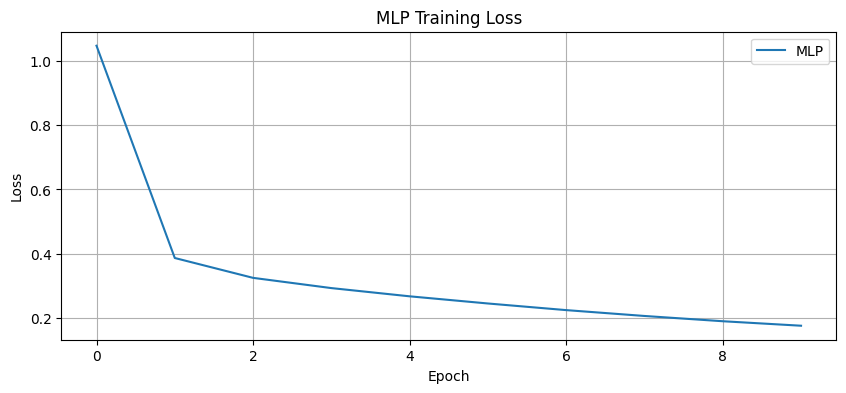

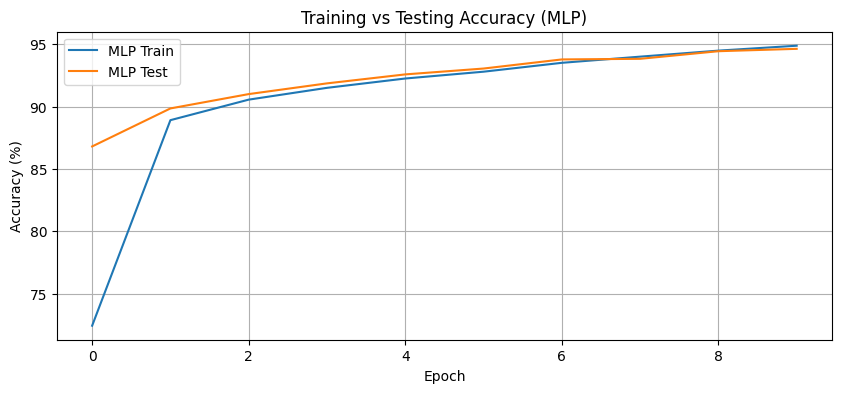

In [ ]:
# training loss
plt.figure(figsize=(10, 4))
plt.plot(mlp_train_losses, label='MLP')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# train vs test
plt.figure(figsize=(10, 4))
plt.plot(mlp_train_accuracies, label='MLP Train')
plt.plot(mlp_test_accuracies, label='MLP Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Testing Accuracy (MLP)')
plt.legend()
plt.grid(True)
plt.show()

# CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 32 * 7 * 7)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


ACCURACY

In [ ]:
def evaluate_model_accuracy(model, test_loader):

  model.eval()

  correct = 0
  total = 0

  device = next(model.parameters()).device

  with torch.no_grad():
      for images, labels in test_loader:

          # cpu to gpu
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  model.train()
  accuracy = 100 * correct / total
  return accuracy


TRAINING LOOP

In [ ]:
model = CNNNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

cnn_train_losses = []
cnn_train_accuracies = []
cnn_test_accuracies = []

num_epochs = 10

start_train = time.time()

torch.cuda.reset_peak_memory_stats()

total_avg_memory = 0

for epoch in range(num_epochs):

    running_loss = 0.0
    correct = 0
    total = 0
    total_memory = 0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # training accuracy for this batch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        total_memory += torch.cuda.memory_allocated()

    avg_memory = total_memory / len(train_loader) / 1024**2  # convert to MB

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    test_acc = evaluate_model_accuracy(model, test_loader)

    cnn_train_losses.append(train_loss)
    cnn_train_accuracies.append(train_acc)
    cnn_test_accuracies.append(test_acc)

    total_avg_memory += avg_memory

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Avg Memory Allocated (GPU): {avg_memory:.2f} MB")

overall_avg_memory = total_avg_memory / num_epochs

end_train = time.time()

print(f"\nTotal Training Time: {end_train - start_train:.2f} seconds")
print(f"Overall Average Memory Allocated (GPU) during Training: {overall_avg_memory:.2f} MB")


Epoch [1/10] | Loss: 1.0368 | Train Acc: 73.22% | Avg Memory Allocated (GPU): 19.06 MB
Epoch [2/10] | Loss: 0.2143 | Train Acc: 93.58% | Avg Memory Allocated (GPU): 19.05 MB
Epoch [3/10] | Loss: 0.1374 | Train Acc: 95.95% | Avg Memory Allocated (GPU): 19.06 MB
Epoch [4/10] | Loss: 0.1051 | Train Acc: 96.90% | Avg Memory Allocated (GPU): 19.05 MB
Epoch [5/10] | Loss: 0.0876 | Train Acc: 97.42% | Avg Memory Allocated (GPU): 19.06 MB
Epoch [6/10] | Loss: 0.0771 | Train Acc: 97.70% | Avg Memory Allocated (GPU): 19.06 MB
Epoch [7/10] | Loss: 0.0691 | Train Acc: 97.91% | Avg Memory Allocated (GPU): 19.05 MB
Epoch [8/10] | Loss: 0.0628 | Train Acc: 98.08% | Avg Memory Allocated (GPU): 19.06 MB
Epoch [9/10] | Loss: 0.0576 | Train Acc: 98.27% | Avg Memory Allocated (GPU): 19.06 MB
Epoch [10/10] | Loss: 0.0534 | Train Acc: 98.36% | Avg Memory Allocated (GPU): 19.06 MB

Total Training Time: 155.97 seconds
Overall Average Memory Allocated (GPU) during Training: 19.06 MB


PLOTTING

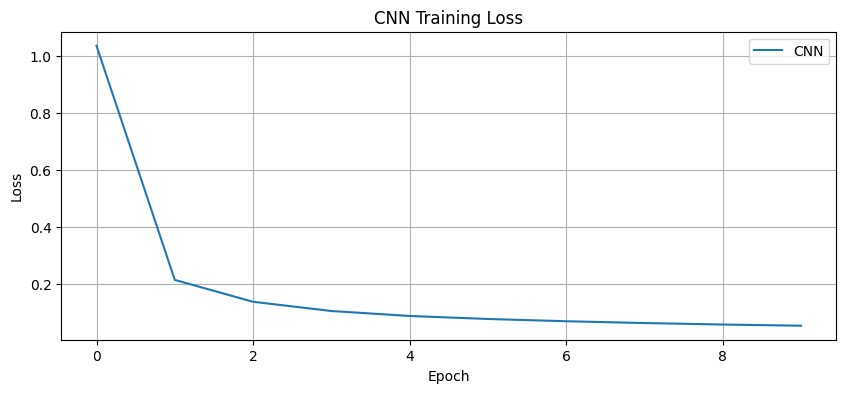

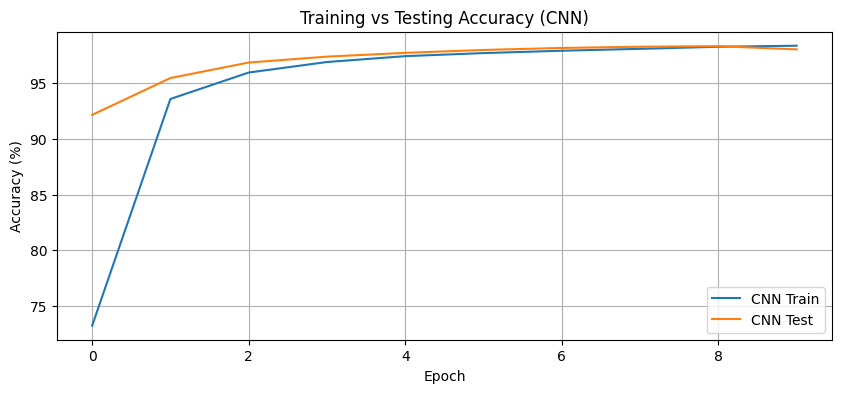

In [ ]:
# plot
plt.figure(figsize=(10, 4))
plt.plot(cnn_train_losses, label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(cnn_train_accuracies, label='CNN Train')
plt.plot(cnn_test_accuracies, label='CNN Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Testing Accuracy (CNN)')
plt.legend()
plt.grid(True)
plt.show()

# RNN

In [ ]:
import torch.nn as nn

class RNNNet(nn.Module):
                 #image size, neruons of hidden layer, number of layers, num of classifications
    def __init__(self, input_size=28, hidden_size=128, num_layers=1, num_classes=10):
        super(RNNNet, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        #initialize
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        #hidden layer calculations
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # reset memory (batch size, num layers, hidden size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) #convert cpu torch zeros to gpu

        out, hidden = self.rnn(x, h0)

        out = self.fc(out[:, -1, :])
        return out


ACCURACY

In [ ]:
def evaluate_model_accuracy_rnn(model, test_loader):

  model.eval()
  correct = 0
  total = 0

  device = next(model.parameters()).device

  with torch.no_grad():
      for images, labels in test_loader:

          images, labels = images.to(device), labels.to(device)

          images = images.squeeze(1)

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  model.train()
  accuracy = 100 * correct / total
  return accuracy


LOOP

In [ ]:
model = RNNNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

rnn_train_losses = []
rnn_train_accuracies = []
rnn_test_accuracies = []

num_epochs = 10

start_train = time.time()

torch.cuda.reset_peak_memory_stats()

total_avg_memory = 0

for epoch in range(num_epochs):

    running_loss = 0.0
    correct = 0
    total = 0
    total_memory = 0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        images = images.squeeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        total_memory += torch.cuda.memory_allocated()

    avg_memory = total_memory / len(train_loader) / 1024**2  # to mb

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    test_acc = evaluate_model_accuracy_rnn(model, test_loader)

    rnn_train_losses.append(train_loss)
    rnn_train_accuracies.append(train_acc)
    rnn_test_accuracies.append(test_acc)

    total_avg_memory += avg_memory

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Avg Memory Allocated (GPU): {avg_memory:.2f} MB")

overall_avg_memory = total_avg_memory / num_epochs

end_train = time.time()

print(f"\nTotal Training Time: {end_train - start_train:.2f} seconds")
print(f"Overall Average Memory Allocated (GPU) during Training: {overall_avg_memory:.2f} MB")

Epoch [1/10] | Loss: 1.9106 | Train Acc: 32.88% | Avg Memory Allocated (GPU): 17.64 MB
Epoch [2/10] | Loss: 1.1294 | Train Acc: 60.17% | Avg Memory Allocated (GPU): 17.64 MB
Epoch [3/10] | Loss: 0.7626 | Train Acc: 73.71% | Avg Memory Allocated (GPU): 17.64 MB
Epoch [4/10] | Loss: 0.5526 | Train Acc: 82.09% | Avg Memory Allocated (GPU): 17.64 MB
Epoch [5/10] | Loss: 0.4182 | Train Acc: 87.08% | Avg Memory Allocated (GPU): 17.63 MB
Epoch [6/10] | Loss: 0.3473 | Train Acc: 89.63% | Avg Memory Allocated (GPU): 17.64 MB
Epoch [7/10] | Loss: 0.2805 | Train Acc: 91.75% | Avg Memory Allocated (GPU): 17.64 MB
Epoch [8/10] | Loss: 0.2420 | Train Acc: 92.84% | Avg Memory Allocated (GPU): 17.64 MB
Epoch [9/10] | Loss: 0.2047 | Train Acc: 93.96% | Avg Memory Allocated (GPU): 17.64 MB
Epoch [10/10] | Loss: 0.1875 | Train Acc: 94.64% | Avg Memory Allocated (GPU): 17.64 MB

Total Training Time: 147.31 seconds
Overall Average Memory Allocated (GPU) during Training: 17.64 MB


PLOTTING

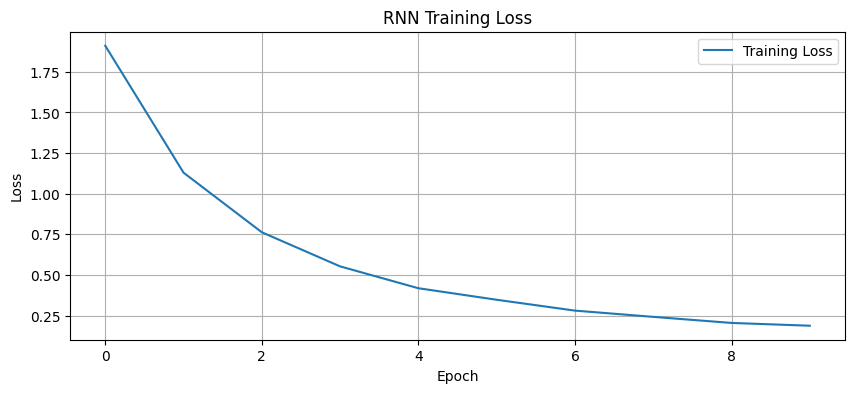

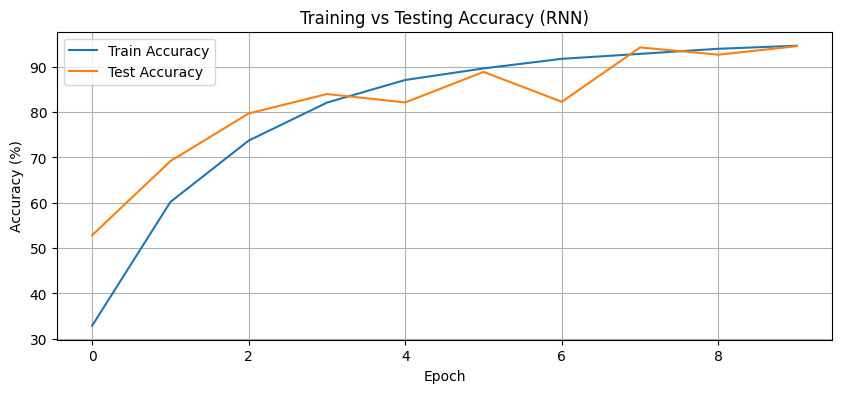

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(rnn_train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RNN Training Loss')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(rnn_train_accuracies, label='Train Accuracy')
plt.plot(rnn_test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Testing Accuracy (RNN)')
plt.grid(True)
plt.legend()
plt.show()


# KNN

k=1 | Train Acc: 100.00%
k=2 | Train Acc: 96.62%
k=3 | Train Acc: 97.00%
k=4 | Train Acc: 96.02%
k=5 | Train Acc: 95.76%
k=6 | Train Acc: 95.26%
k=7 | Train Acc: 95.06%
k=8 | Train Acc: 94.66%
k=9 | Train Acc: 94.46%
k=10 | Train Acc: 94.04%
k=11 | Train Acc: 93.98%
k=12 | Train Acc: 93.52%
k=13 | Train Acc: 93.46%
k=14 | Train Acc: 93.24%
k=15 | Train Acc: 93.10%


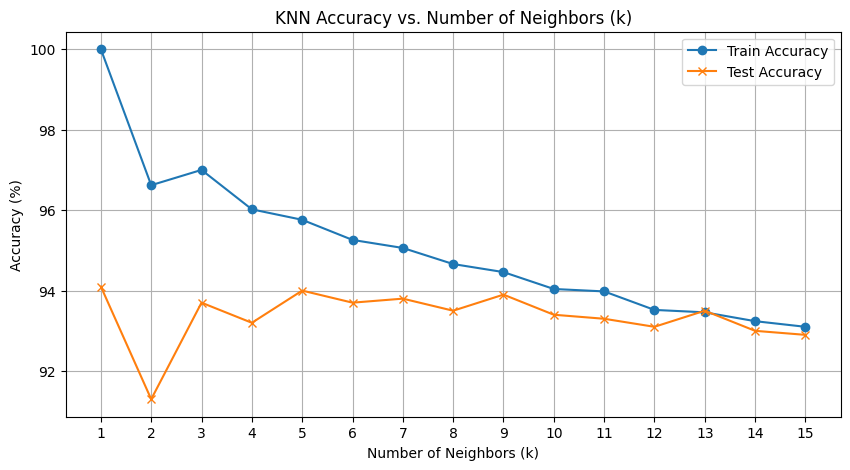


Total Training Time: 5.10 seconds
Memory Usage: 9.21 MB (Δ during KNN fit)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
import psutil
import time

# Set seed for reproducibility
np.random.seed(42)

# Convert to arrays
X_train = train_dataset.data.numpy().reshape(-1, 28*28) / 255.0
y_train = train_dataset.targets.numpy()

X_test = test_dataset.data.numpy().reshape(-1, 28*28) / 255.0
y_test = test_dataset.targets.numpy()

# Sample MNIST using fixed random seed
indices_train = np.random.choice(len(X_train), 5000, replace=False)
indices_test = np.random.choice(len(X_test), 1000, replace=False)

X_train_small = X_train[indices_train]
y_train_small = y_train[indices_train]
X_test_small = X_test[indices_test]
y_test_small = y_test[indices_test]

k_values = list(range(1, 16))
train_accuracies = []
test_accuracies = []

# Start time + memory
process = psutil.Process()
initial_memory = process.memory_info().rss / 1024**2  # MB
start_train = time.time()

# Loop through values for k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_small, y_train_small)

    train_acc = knn.score(X_train_small, y_train_small) * 100
    test_acc = knn.score(X_test_small, y_test_small) * 100

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"k={k} | Train Acc: {train_acc:.2f}%")

# End time + memory
end_train = time.time()
final_memory = process.memory_info().rss / 1024**2  # MB

# Accuracy vs k plot
plt.figure(figsize=(10, 5))
plt.plot(k_values, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(k_values, test_accuracies, label="Test Accuracy", marker='x')
plt.title("KNN Accuracy vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy (%)")
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

# Output system usage
print(f"\nTotal Training Time: {end_train - start_train:.2f} seconds")
print(f"Memory Usage: {final_memory - initial_memory:.2f} MB (Δ during KNN fit)")
